In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('hospitaldata.csv')
df=pd.DataFrame(df)
print("Dataset shape:", df.shape)

Dataset shape: (101763, 47)


In [5]:
# Display the first few rows
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,encounter_id,patient_nbr,race,gender,age,weight,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),Unknown,_Other,Referral,1,Other,...,No,No,No,No,No,No,No,No,No,No
1,149190,55629189,Caucasian,Female,[10-20),Unknown,Home,Emergency,3,Other,...,No,No,Up,No,No,No,No,Yes,Yes,After30Days
2,64410,86047875,AfricanAmerican,Female,[20-30),Unknown,Home,Emergency,2,Other,...,No,No,No,No,No,No,No,No,Yes,No
3,500364,82442376,Caucasian,Male,[30-40),Unknown,Home,Emergency,2,Other,...,No,No,Up,No,No,No,No,Yes,Yes,No
4,16680,42519267,Caucasian,Male,[40-50),Unknown,Home,Emergency,1,Other,...,No,No,Steady,No,No,No,No,Yes,Yes,No


In [6]:
# Description of the Data Set
print("Description of the dataset:")
df.describe()

Description of the dataset:


,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017630e+05,1.017630e+05,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,1.652008e+08,5.432965e+07,4.396018,43.095909,1.339691,16.021835,0.369368,0.197842,0.635585,7.422649
std,1.026410e+08,3.869658e+07,2.985092,19.674220,1.705792,8.127589,1.267282,0.930485,1.262877,1.933578
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.495975e+07,2.341296e+07,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523883e+08,4.550049e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302698e+08,8.754571e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [7]:
# Check the target variable distribution
print("Target variable (readmitted) distribution:")
print(df['readmitted'].value_counts())
print(df['readmitted'].value_counts(normalize=True).round(3) * 100)

Target variable (readmitted) distribution:
readmitted
No              54861
After30Days     35545
Within30Days    11357
Name: count, dtype: int64
readmitted
No              53.9
After30Days     34.9
Within30Days    11.2
Name: proportion, dtype: float64


In [8]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
Series([], dtype: int64)


In [9]:
# Check data types
print("Data types:")
df.dtypes

Data types:


encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide           

In [10]:
# Check unique values in categorical columns
print("Unique values in 'readmitted':", df['readmitted'].unique())

Unique values in 'readmitted': ['No' 'After30Days' 'Within30Days']


In [11]:
# Since we have three classes in 'readmitted', let's create a binary target
# 'Within30Days' vs 'Not Within30Days' (combining 'No' and 'After30Days')
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == 'Within30Days' else 0)

In [12]:
# Check the distribution of the binary target
print("Binary target distribution:")
print(df['readmitted_binary'].value_counts())
print(df['readmitted_binary'].value_counts(normalize=True))

Binary target distribution:
readmitted_binary
0    90406
1    11357
Name: count, dtype: int64
readmitted_binary
0    0.888398
1    0.111602
Name: proportion, dtype: float64


In [13]:
# Let's look at some key features
print("Age distribution:")
print(df['age'].value_counts())

print("Gender distribution:")
print(df['gender'].value_counts())

print("Time in hospital statistics:")
print(df['time_in_hospital'].describe())

Age distribution:
age
[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64
Gender distribution:
gender
Female    54708
Male      47055
Name: count, dtype: int64
Time in hospital statistics:
count    101763.000000
mean          4.396018
std           2.985092
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          14.000000
Name: time_in_hospital, dtype: float64


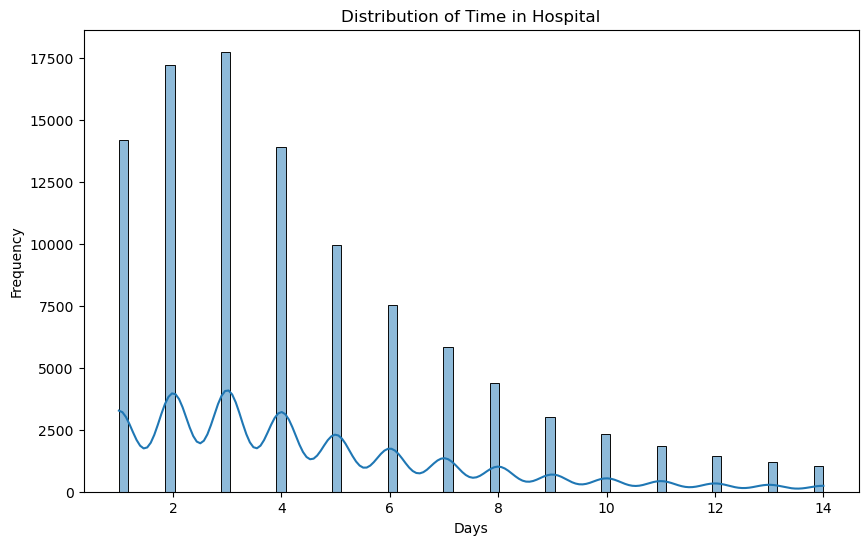

In [14]:
# Visualize the distribution of time in hospital
plt.figure(figsize=(10, 6))
sns.histplot(df['time_in_hospital'], kde=True)
plt.title('Distribution of Time in Hospital')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Let's check for '?' values which might be used for missing data
for col in df.columns:
    if df[col].dtype == object:  # Only check object columns
        if (df[col] == '?').any():
            print(f"Column {col} has '?' values: {(df[col] == '?').sum()}")

Column diag_1 has '?' values: 21
Column diag_2 has '?' values: 358
Column diag_3 has '?' values: 1423


In [16]:
# Replace '?' with NaN for proper handling
df = df.replace('?', np.nan)

In [17]:
# Convert diag columns to numeric, errors='coerce' will convert non-numeric to NaN
df['diag_1'] = pd.to_numeric(df['diag_1'], errors='coerce')
df['diag_2'] = pd.to_numeric(df['diag_2'], errors='coerce')
df['diag_3'] = pd.to_numeric(df['diag_3'], errors='coerce')

In [18]:
# Let's select features for our model
# Exclude ID columns and the original readmitted column
features = df.drop(['encounter_id', 'patient_nbr', 'readmitted', 'readmitted_binary'], axis=1)

In [19]:
# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()
numerical_cols = features.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:\n", categorical_cols)
print("\nNumber of categorical columns:", len(categorical_cols))
print("\nNumerical columns:\n", numerical_cols)
print("\nNumber of numerical columns:", len(numerical_cols))

Categorical columns:
 ['race', 'gender', 'age', 'weight', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide_metformin', 'glipizide_metformin', 'glimepiride_pioglitazone', 'metformin_pioglitazone', 'change', 'diabetesMed']

Number of categorical columns: 33

Numerical columns:
 ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses']

Number of numerical columns: 11


In [20]:
# Target variable
y = df['readmitted_binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Positive class percentage in training:", y_train.mean() * 100)
print("Positive class percentage in testing:", y_test.mean() * 100)

Training set shape: (81410, 44)
Testing set shape: (20353, 44)
Positive class percentage in training: 11.16079105760963
Positive class percentage in testing: 11.158060236820125


In [21]:
# Create preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
# Create preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [23]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [24]:
# Create the full pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif, k=50)),  # Select top 50 features
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

In [25]:
# Define hyperparameters for grid search
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'],  # liblinear supports both l1 and l2
    'classifier__class_weight': [None, 'balanced']
}

In [26]:
# Create Halving Grid Search
halving_grid_search = HalvingGridSearchCV(
    pipeline,
    param_grid,
    cv=3,  # Reduced number of cross-validation folds
    scoring='roc_auc',
    n_jobs=-1,  # Use all available CPU cores
    verbose=1
)

In [27]:
print("Starting halving grid search...")
halving_grid_search.fit(X_train, y_train)
print("Halving grid search completed.")

Starting halving grid search...
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 9045
max_resources_: 81410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 9045
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 8
n_resources: 27135
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 2
n_candidates: 3
n_resources: 81405
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Halving grid search completed.


In [28]:
# Get the best model
best_model = halving_grid_search.best_estimator_
print("Best parameters:", halving_grid_search.best_params_)
print("Best cross-validation score:", halving_grid_search.best_score_)

Best parameters: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.6439821847803521


In [29]:
# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

In [30]:
# Calculate accuracy
accuracy = best_model.score(X_test, y_test)
print("Model Accuracy:", round(accuracy, 4))

Model Accuracy: 0.6547


In [31]:
# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Test ROC AUC:", roc_auc)

Test ROC AUC: 0.6532555030508067


In [32]:
# Print classification report
print("\
Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.78     18082
           1       0.17      0.53      0.26      2271

    accuracy                           0.65     20353
   macro avg       0.54      0.60      0.52     20353
weighted avg       0.84      0.65      0.72     20353



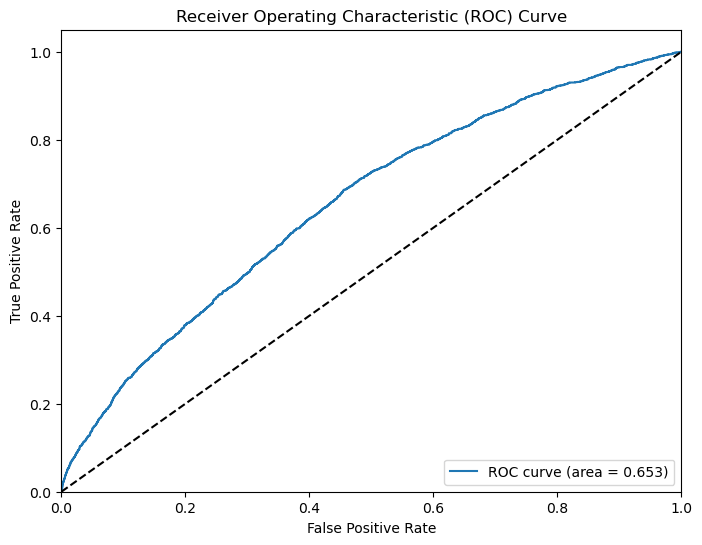

In [33]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

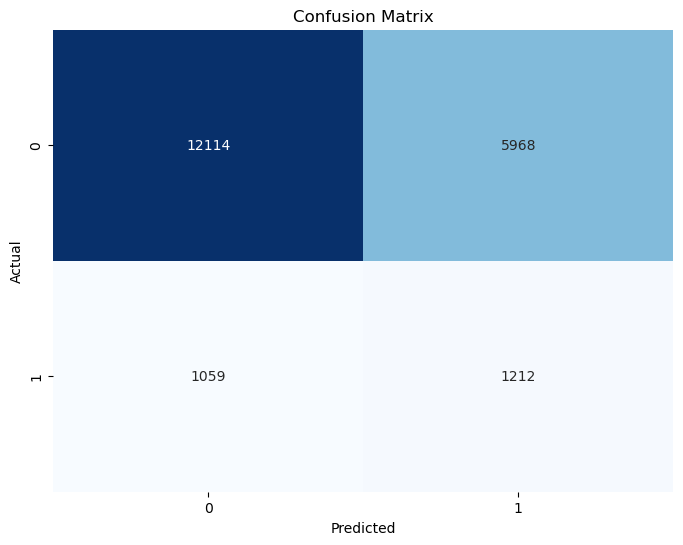

In [34]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Some visualizations to help understand the hospital readmission data better

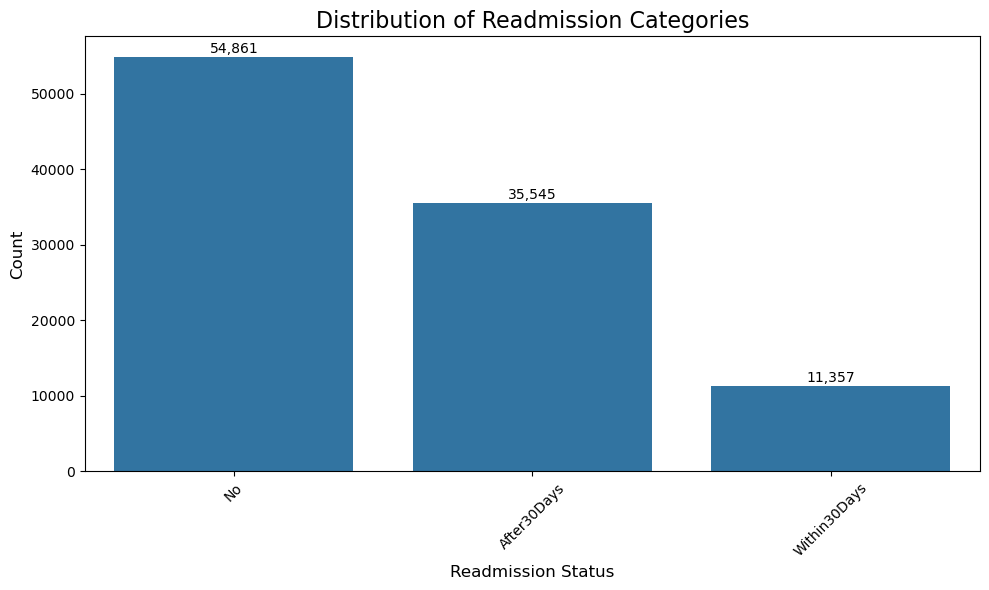

In [36]:
#1. Distribution of readmission categories
plt.figure(figsize=(10, 6))
readmission_counts = df['readmitted'].value_counts()
ax = sns.barplot(x=readmission_counts.index, y=readmission_counts.values)
plt.title('Distribution of Readmission Categories', fontsize=16)
plt.xlabel('Readmission Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Add count labels on top of bars
for i, count in enumerate(readmission_counts.values):
    ax.text(i, count + 500, f'{count:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

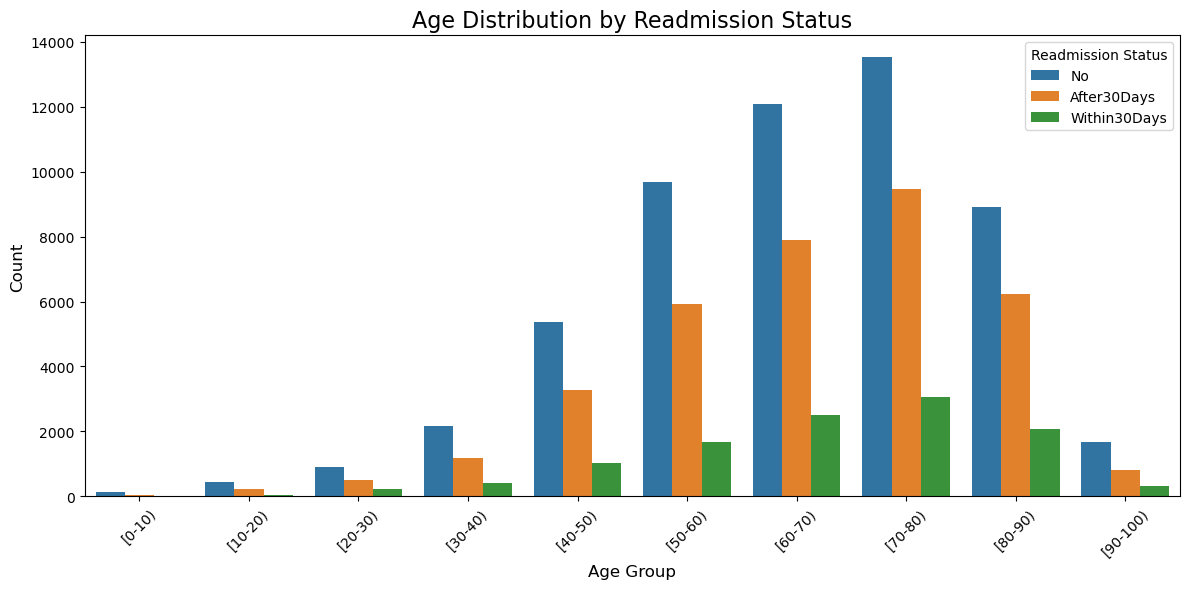

In [37]:
# 2. Age distribution by readmission status
plt.figure(figsize=(12, 6))
age_order = sorted(df['age'].unique(), key=lambda x: int(x.split('-')[0][1:] if x.startswith('[') else 0))
sns.countplot(data=df, x='age', hue='readmitted', order=age_order)
plt.title('Age Distribution by Readmission Status', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Readmission Status')
plt.tight_layout()
plt.show()

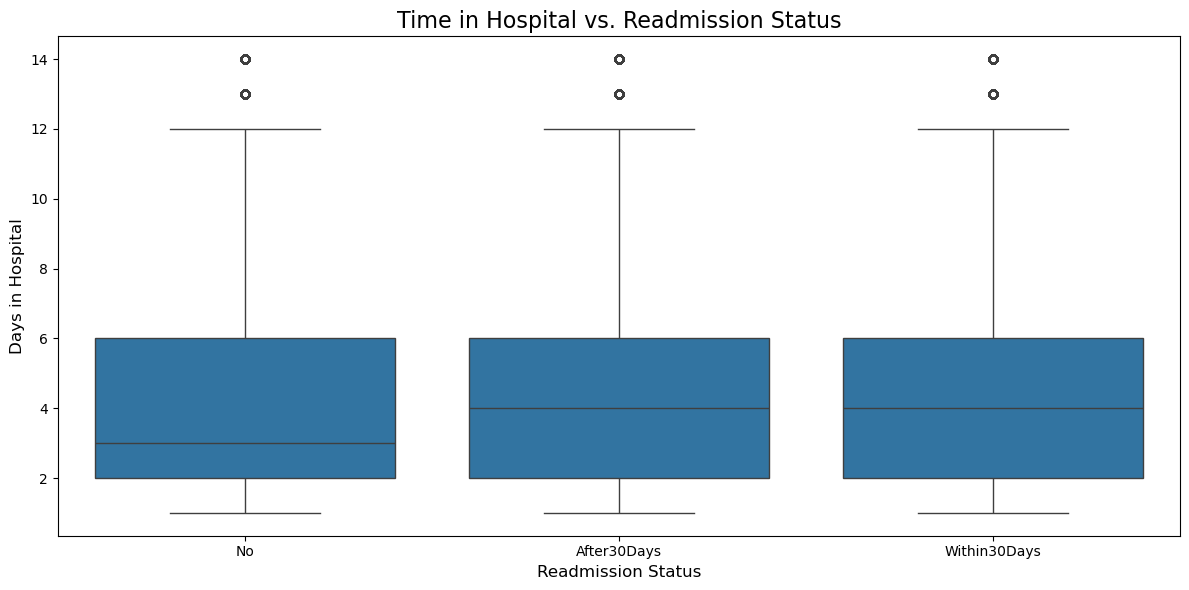

In [38]:
# 3. Time in hospital vs. readmission
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='readmitted', y='time_in_hospital')
plt.title('Time in Hospital vs. Readmission Status', fontsize=16)
plt.xlabel('Readmission Status', fontsize=12)
plt.ylabel('Days in Hospital', fontsize=12)
plt.tight_layout()
plt.show()

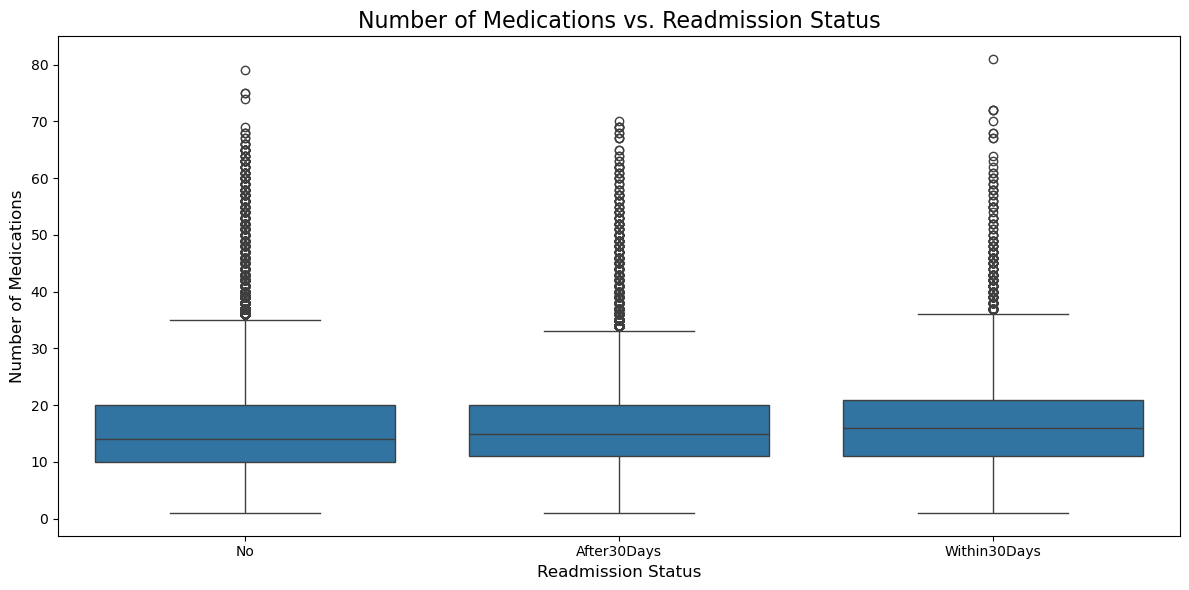

In [39]:
# 4. Number of medications vs. readmission
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='readmitted', y='num_medications')
plt.title('Number of Medications vs. Readmission Status', fontsize=16)
plt.xlabel('Readmission Status', fontsize=12)
plt.ylabel('Number of Medications', fontsize=12)
plt.tight_layout()
plt.show()

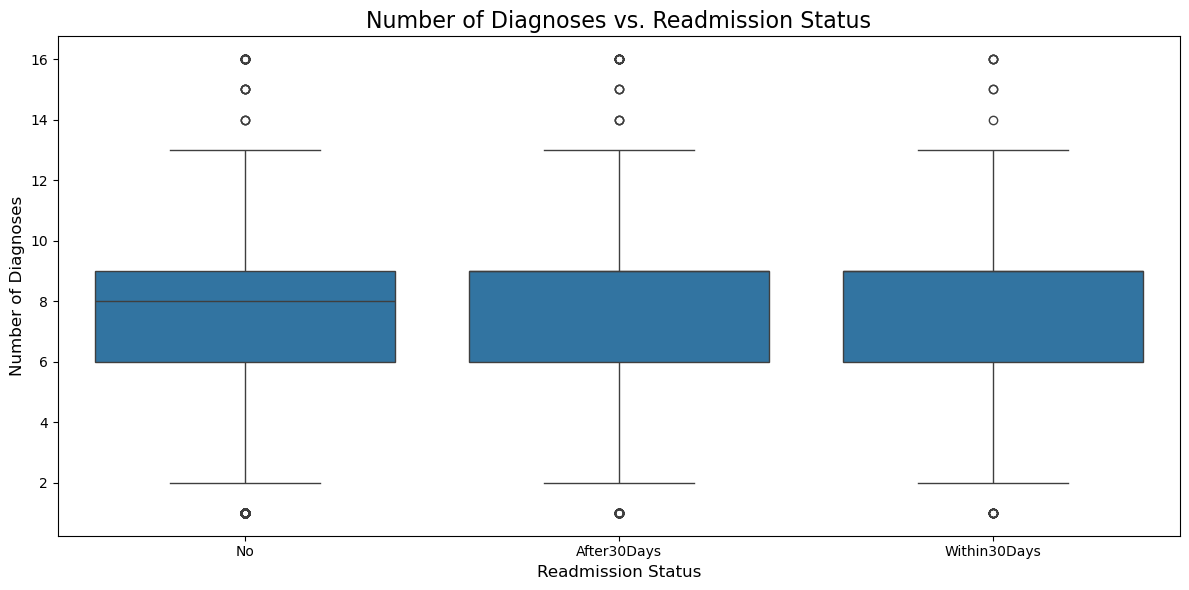

In [40]:
# 5. Number of diagnoses vs. readmission
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='readmitted', y='number_diagnoses')
plt.title('Number of Diagnoses vs. Readmission Status', fontsize=16)
plt.xlabel('Readmission Status', fontsize=12)
plt.ylabel('Number of Diagnoses', fontsize=12)
plt.tight_layout()
plt.show()

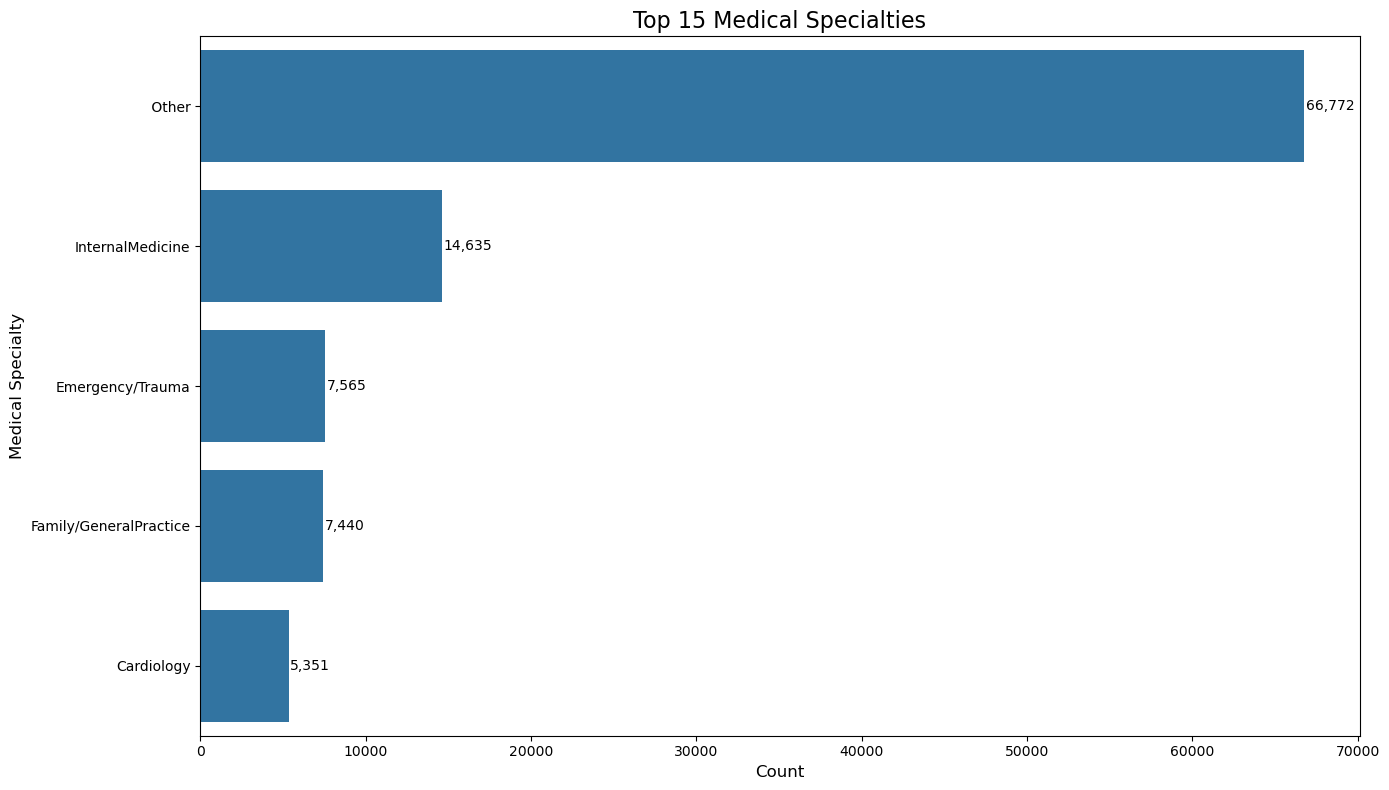

In [41]:
# 6. Medical specialty distribution (top 15)
plt.figure(figsize=(14, 8))
specialty_counts = df['medical_specialty'].value_counts().head(15)
ax = sns.barplot(x=specialty_counts.values, y=specialty_counts.index)
plt.title('Top 15 Medical Specialties', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Medical Specialty', fontsize=12)

# Add count labels on bars
for i, count in enumerate(specialty_counts.values):
    ax.text(count + 100, i, f'{count:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

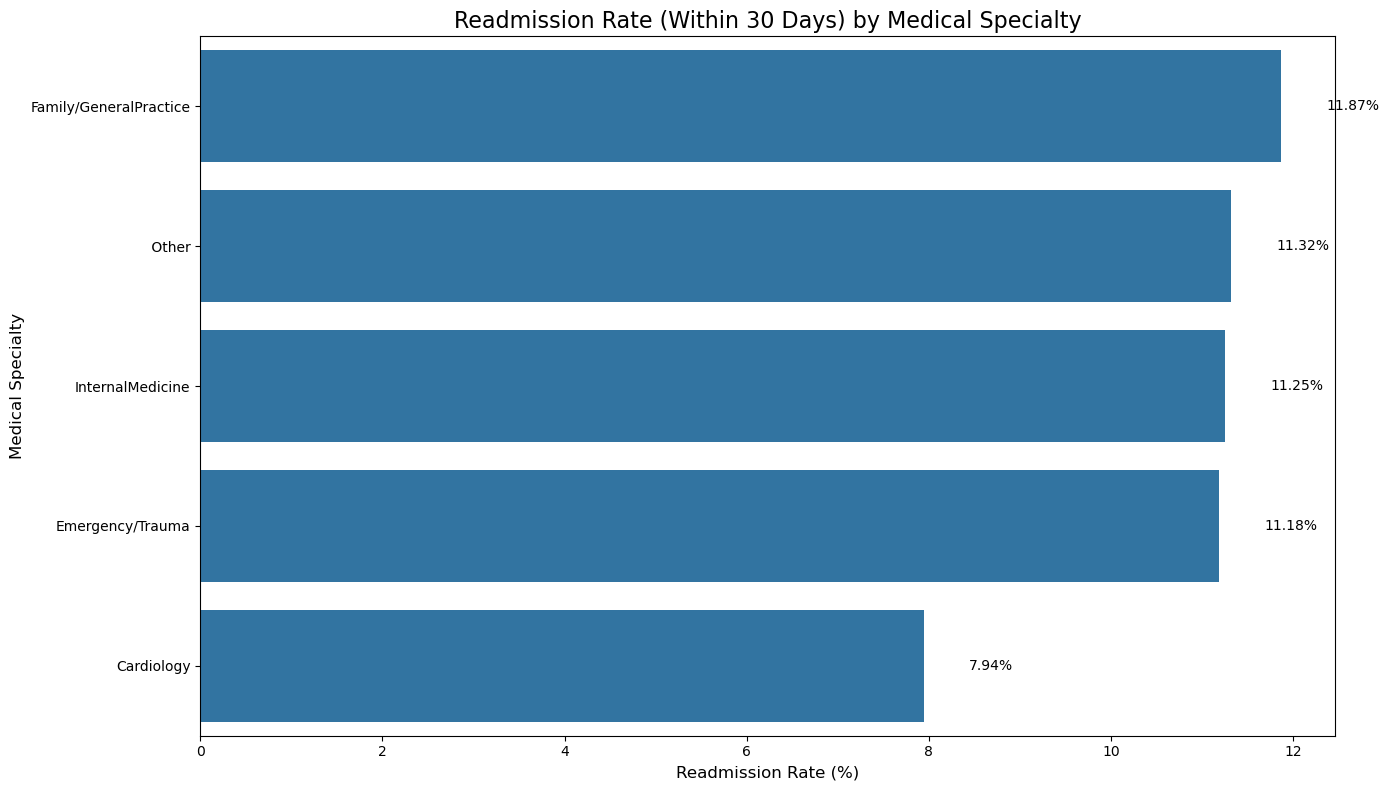

In [42]:
# 7. Readmission rate by medical specialty (top 15 specialties)
top_specialties = df['medical_specialty'].value_counts().head(15).index
specialty_df = df[df['medical_specialty'].isin(top_specialties)]

plt.figure(figsize=(14, 8))
readmission_by_specialty = specialty_df.groupby('medical_specialty')['readmitted_binary'].mean().sort_values(ascending=False)
ax = sns.barplot(x=readmission_by_specialty.values * 100, y=readmission_by_specialty.index)
plt.title('Readmission Rate (Within 30 Days) by Medical Specialty', fontsize=16)
plt.xlabel('Readmission Rate (%)', fontsize=12)
plt.ylabel('Medical Specialty', fontsize=12)

# Add percentage labels on bars
for i, rate in enumerate(readmission_by_specialty.values):
    ax.text(rate * 100 + 0.5, i, f'{rate*100:.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

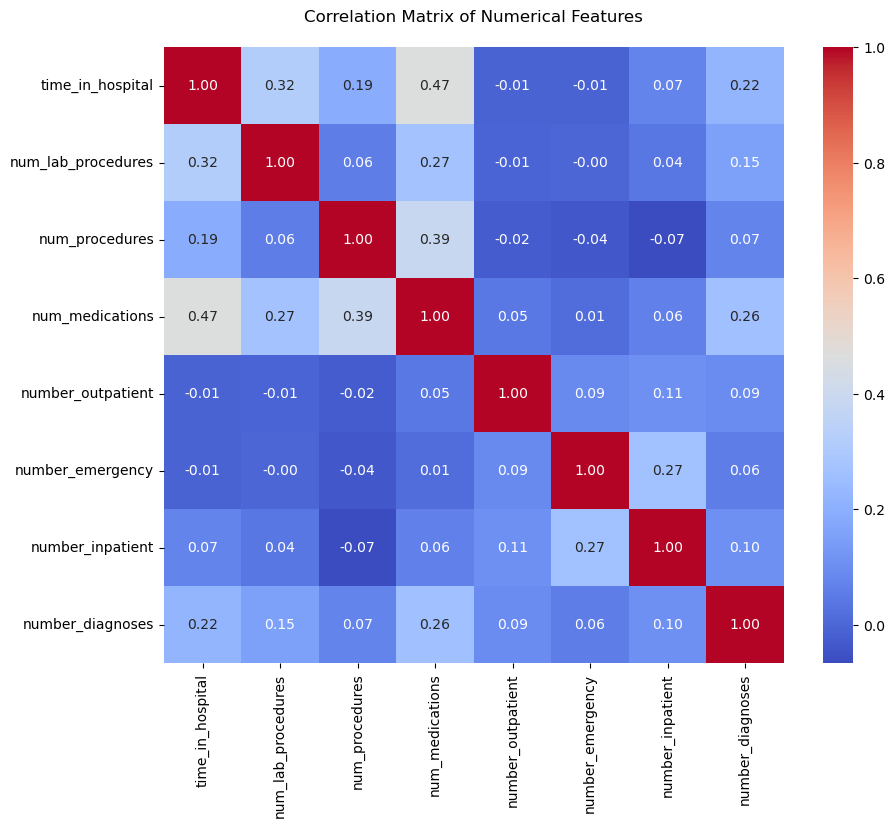

In [89]:
# 8. Correlation heatmap of numerical features
numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                 'num_medications', 'number_outpatient', 'number_emergency', 
                 'number_inpatient', 'number_diagnoses']
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features\n')
plt.show()

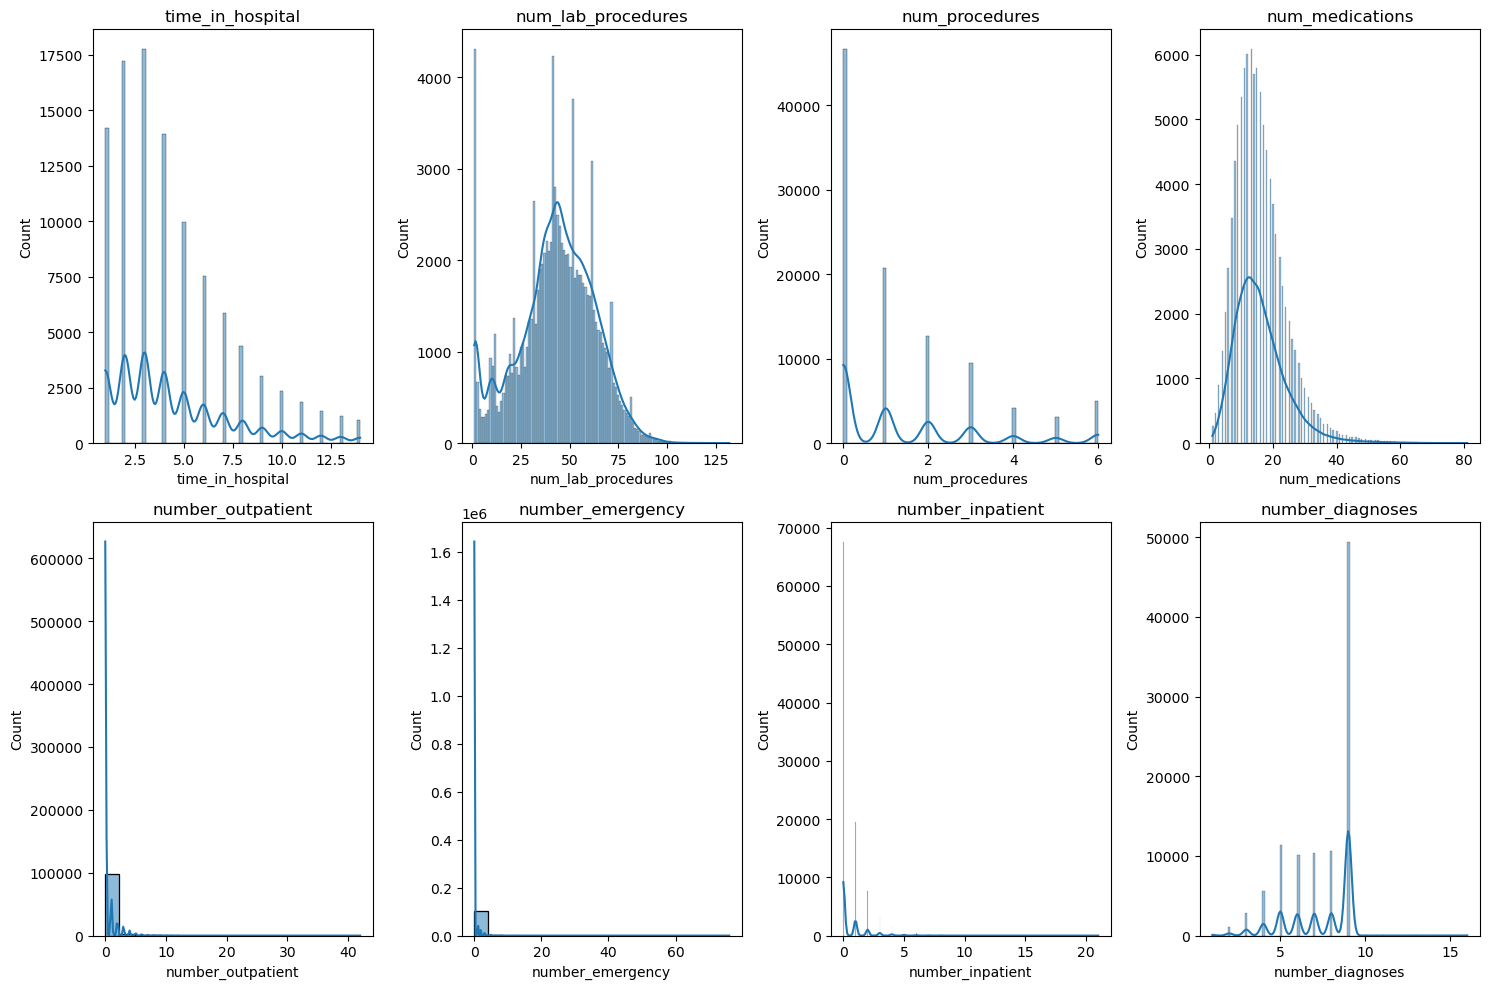

In [44]:
#9. Create a figure for histograms
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

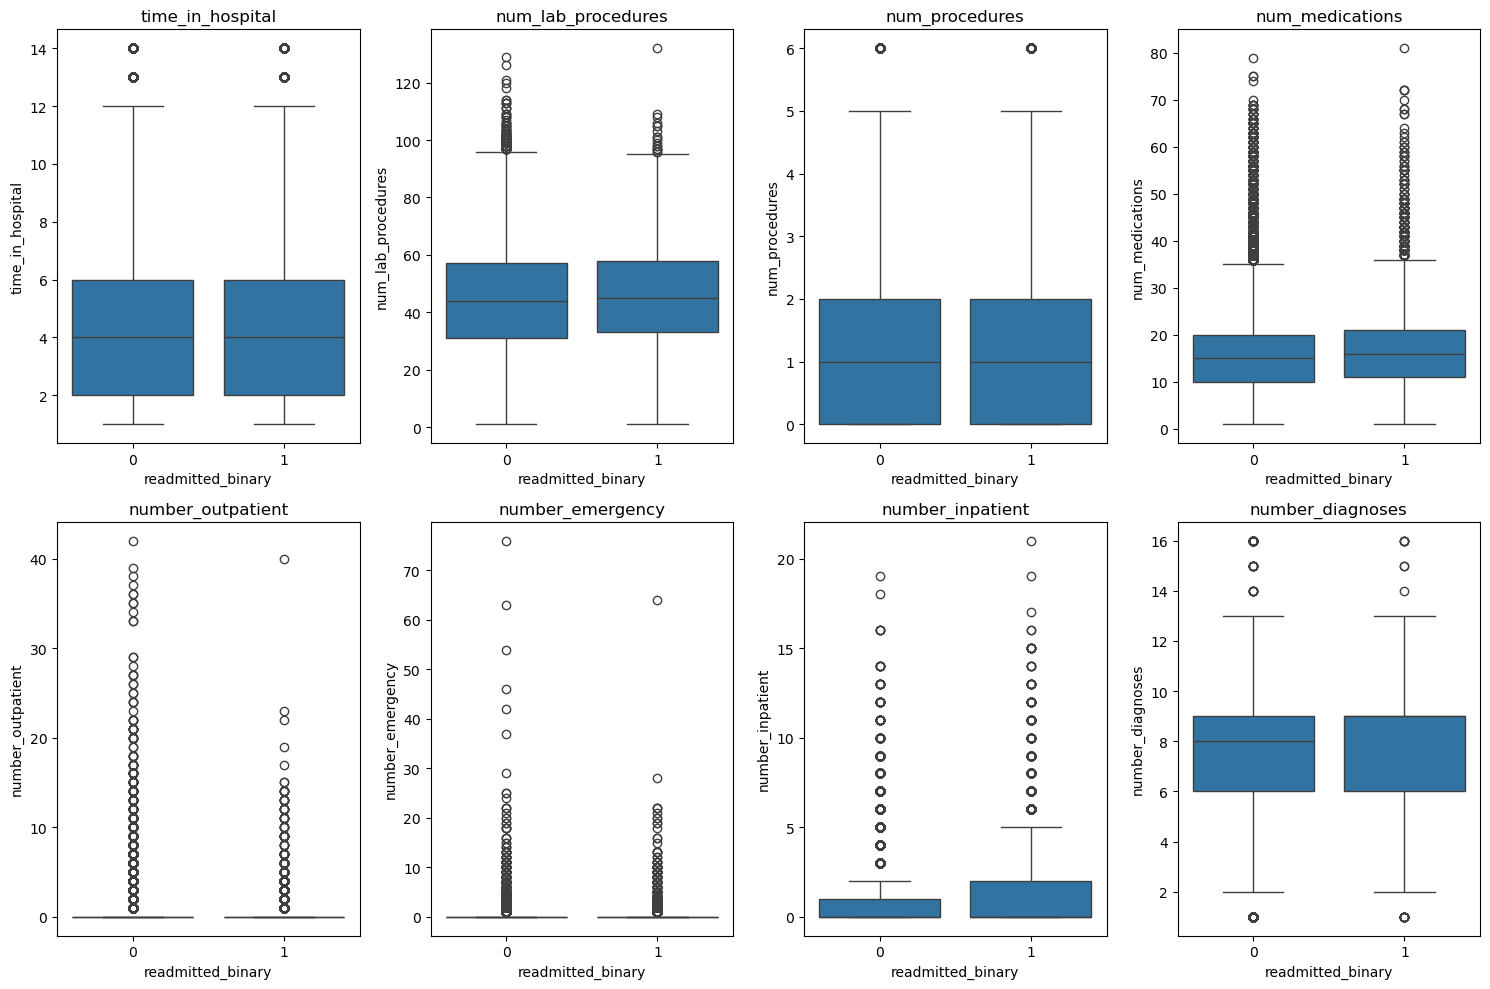

In [45]:
#10. Check if there's a relationship between numerical features and readmission
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(x='readmitted_binary', y=feature, data=df)
    plt.title(feature)
plt.tight_layout()
plt.show()